In [55]:
import numpy as np
import kaggle as kg
import os
import zipfile
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import Model, Sequential
from keras.layers import *
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import f1_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.image import resize


In [34]:
# Thiết lập chung
ds_path = 'datasets/covid-segmentation'

In [26]:
# Tải dữ liệu từ thư viện Kaggle

kg.api.authenticate()
kg.api.competition_download_files(
    competition='covid-segmentation',
    quiet=False,
    path=ds_path
)

# Giải nén tập dữ liệu
with zipfile.ZipFile(os.path.join(ds_path, 'covid-segmentation.zip'), 'r') as zipfile:
    zipfile.extractall(ds_path)


covid-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [33]:
# Nạp data vào mảng
images_medseg = np.load(os.path.join(
    ds_path, 'images_medseg.npy')).astype(np.float32)
images_radiopedia = np.load(os.path.join(
    ds_path, 'images_radiopedia.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(
    ds_path, 'masks_medseg.npy')).astype(np.int8)
masks_radiopedia = np.load(os.path.join(
    ds_path, 'masks_radiopedia.npy')).astype(np.int8)
test_images_medseg = np.load(os.path.join(
    ds_path, 'test_images_medseg.npy')).astype(np.float32)

print(images_medseg.shape, masks_medseg.shape,
      images_radiopedia.shape, masks_radiopedia.shape)


(100, 512, 512, 1) (100, 512, 512, 4) (829, 512, 512, 1) (829, 512, 512, 4)


In [ ]:
# Tạo nhãn cho tập dữ liệu
classes = ['ground glass', 'consolidations', 'lungs other', 'background']
num_classes = len(classes)

In [50]:
# Khởi tạo hàm xem ảnh & mặt nạ phân đoạn ngẫu nhiên (bỏ qua class lung_other do không cần thiết)
def view_image_mask_rand(images, masks):
    for c in range(0, num_classes - 2):
        for i in range(0, 10):
            a = random.randint(0, images.shape[0] - 1)
            plt.subplot(2, 5, i + 1)
            # Tạo mảng 3 chiều toàn giá trị 0 ứng với 3 kênh RGB
            mask_to_show = np.zeros(shape=(*masks.shape[1:3], 3))
            # Hiển thị class thứ 0 ở kênh R
            mask_to_show[..., 0] = masks[a, :, :, c]
            # Hiển thị class thứ 3 (background) ở kênh G
            mask_to_show[..., 1] = masks[a, :, :, 3]
            plt.imshow(mask_to_show)
        plt.show()


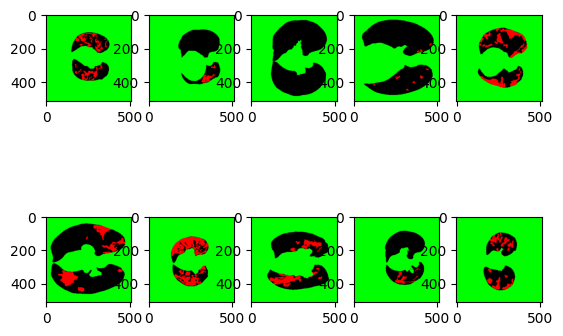

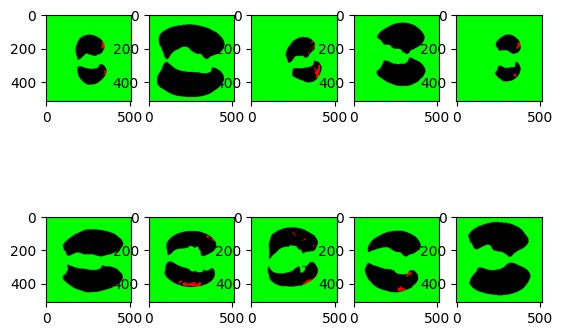

In [49]:
view_image_mask_rand(images_medseg, masks_medseg)

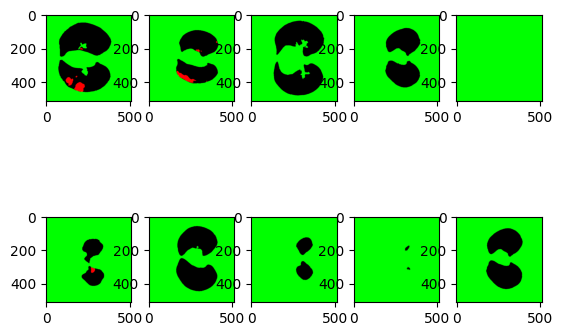

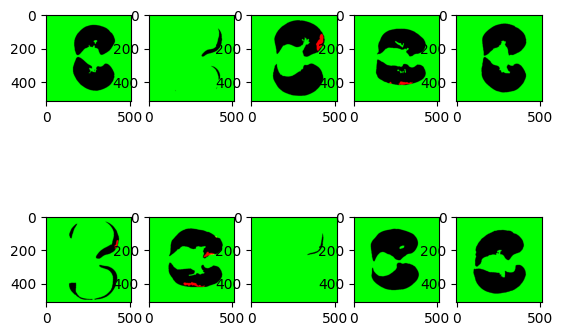

In [51]:
view_image_mask_rand(images_radiopedia, masks_radiopedia)

In [52]:
# Gộp 2 tập medseg & radiopedia & tách tập dữ liệu để Train/Test
train_images = np.concatenate((images_medseg, images_radiopedia), axis=0)
train_masks = np.concatenate((masks_medseg, masks_radiopedia), axis=0)


In [53]:
# Resize ảnh & mask về kích thước 128x128 do không đủ ram
img_size = (128, 128, 1)

train_images = resize(train_images, size=img_size[:2]).numpy()
train_masks = resize(train_masks, size=img_size[:2]).numpy()

print('Kích thước mới\n', train_images.shape, train_masks.shape)


Kích thước mới
 (929, 128, 128, 1) (929, 128, 128, 4)


In [42]:
# Tách mảng tỉ lệ 80:20 để Train/Test
x_train, x_test, y_train, y_test = train_test_split(
    train_images,
    train_masks,
    test_size=.20,
    random_state=50
)
print('Thống kê dataset')
print(f'TRAIN: {y_train.shape[0]}')
print(f'TEST: {y_test.shape[0]}')


Thống kê dataset
TRAIN: 743
TEST: 186


In [57]:
# Định nghĩa hàm đánh giá các lớp
def f1_score_class_0(y_true, y_pred):
    return y_true[..., :1], y_pred[..., :1] # class 0


def f1_score_class_1(y_true, y_pred):
    return y_true[..., 1:2], y_pred[..., 1:2] # class 1


def f1_score_class_2(y_true, y_pred):
    return y_true[..., 2:3], y_pred[..., 2:3] # class 2


def f1_score_class_0_1(y_true, y_pred): 
    return y_true[..., :2], y_pred[..., :2] # class 0-1

# Định nghĩa các hàm callbacks


def early_stopping_callback():
    return EarlyStopping(
        monitor='loss',
        patience=3,
        restore_best_weights=True
    )
def model_checkpoint_callback():
    return ModelCheckpoint(
        'covid_19/best_model/',
        monitor='f1_score_class_0_1',
        save_best_only=True,
        mode='max'
    )


In [59]:
# Xây dựng mô hình đào tạo Unet
def my_model():
    inputs = Input(img_size)
    s = Conv2D(3, (1, 1))(inputs)  # Convert 1 channels to 3 channels
    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu',
                kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu',
                kernel_initializer='he_normal', padding='same')(c1)
    b1 = BatchNormalization()(c1)
    r1 = ReLU()(b1)
    p1 = MaxPooling2D((2, 2))(r1)

    c2 = Conv2D(32, (3, 3), activation='relu',
                kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu',
                kernel_initializer='he_normal', padding='same')(c2)
    b2 = BatchNormalization()(c2)
    r2 = ReLU()(b2)
    p2 = MaxPooling2D((2, 2))(r2)

    c3 = Conv2D(64, (3, 3), activation='relu',
                kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu',
                kernel_initializer='he_normal', padding='same')(c3)
    b3 = BatchNormalization()(c3)
    r3 = ReLU()(b3)
    p3 = MaxPooling2D((2, 2))(r3)

    c4 = Conv2D(128, (3, 3), activation='relu',
                kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu',
                kernel_initializer='he_normal', padding='same')(c4)
    b4 = BatchNormalization()(c4)
    r4 = ReLU()(b4)
    p4 = MaxPooling2D(pool_size=(2, 2))(r4)

    c5 = Conv2D(256, (3, 3), activation='relu',
                kernel_initializer='he_normal', padding='same')(p4)
    b5 = BatchNormalization()(c5)
    r5 = ReLU()(b5)
    c5 = Dropout(0.3)(r5)
    c5 = Conv2D(256, (3, 3), activation='relu',
                kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(
        128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = BatchNormalization()(u6)
    u6 = ReLU()(u6)

    u7 = Conv2DTranspose(
        64, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = concatenate([u7, c3])
    u7 = BatchNormalization()(u7)
    u7 = ReLU()(u7)

    u8 = Conv2DTranspose(
        32, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = concatenate([u8, c2])
    u8 = BatchNormalization()(u8)
    u8 = ReLU()(u8)

    u9 = Conv2DTranspose(
        16, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = BatchNormalization()(u9)
    u9 = ReLU()(u9)
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        'adam',
        CategoricalCrossentropy(),
        [
            f1_score_class_0, f1_score_class_1,
            f1_score_class_2, f1_score_class_0_1
        ]
    )
    return model

In [ ]:
# Chọn mô hình
model = my_model()
# Khái quát mô hình
model.summary()
# Đào tạo mô hình
model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    callbacks=[
        early_stopping_callback(),
        model_checkpoint_callback()
    ]
)